In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import uproot_methods
import glob
import uproot
import uproot_methods
import os
import sys

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors

# !pip install pydot graphviz
import pydot
import graphviz

# !pip install particle
from particle import Particle

In [2]:
def get_df(fname, entry):
    """
    Takes filename of cms4 or nanoaod ntuple
    and entry number (first event in a root file is entry 0)
    """
    t = uproot.open(fname)["Events"]
    kw = dict(entrystart=entry, entrystop=entry+1)
    is_nano = b"GenPart_pt" in t.keys()
    if is_nano:
        mother_idxs = t["GenPart_genPartIdxMother"].array(**kw)[0]
        ids = t["GenPart_pdgId"].array(**kw)[0]
        statuses = t["GenPart_status"].array(**kw)[0]
        pts = t["GenPart_pt"].array(**kw)[0]
        etas = t["GenPart_eta"].array(**kw)[0]
        phis = t["GenPart_phi"].array(**kw)[0]
        masses = t["GenPart_mass"].array(**kw)[0]
        energies = uproot_methods.TLorentzVectorArray.from_ptetaphim(pts,etas,phis,masses).energy
    else:
        mother_idxs = t["genps_idx_mother"].array(**kw)[0]
        ids = t["genps_id"].array(**kw)[0]
        statuses = t["genps_status"].array(**kw)[0]
        xs = t["floatROOTMathPxPyPzE4DROOTMathLorentzVectors_genMaker_genpsp4_CMS3.obj.fCoordinates.fX"].array(**kw)[0]
        ys = t["floatROOTMathPxPyPzE4DROOTMathLorentzVectors_genMaker_genpsp4_CMS3.obj.fCoordinates.fY"].array(**kw)[0]
        zs = t["floatROOTMathPxPyPzE4DROOTMathLorentzVectors_genMaker_genpsp4_CMS3.obj.fCoordinates.fZ"].array(**kw)[0]
        ts = t["floatROOTMathPxPyPzE4DROOTMathLorentzVectors_genMaker_genpsp4_CMS3.obj.fCoordinates.fT"].array(**kw)[0]
        p4s = uproot_methods.TLorentzVectorArray.from_cartesian(xs,ys,zs,ts)
        pts = p4s.pt
        etas = p4s.eta
        phis = p4s.phi
        masses = p4s.mass
        energies = p4s.energy

    df = pd.DataFrame()
    df["mother_idx"] = mother_idxs.astype(int)
    df["id"] = ids.astype(int)
    df["status"] = statuses.astype(int)
    df["pt"] = pts
    df["eta"] = etas
    df["phi"] = phis
    df["mass"] = masses
    df["energy"] = energies
    
    df.loc[df["mother_idx"] == -1, "mother_idx"] = 0

    x = pd.DataFrame(dict(idx=df.index.values, midx=df.mother_idx.values)).groupby("midx")["idx"].count()
    df.loc[x.index, "daughters"] = x.values
    df["daughters"] = df["daughters"].fillna(0).astype(int)
    df["mass"] = df["mass"].fillna(0.)
    return df


In [3]:
fname = "/hadoop/cms/store/group/snt/run2_mc2016_94x//TTToSemiLeptonic_TuneCP5_PSweights_13TeV-powheg-pythia8_RunIISummer16MiniAODv3-PUMoriond17_94X_mcRun2_asymptotic_v3-v1_MINIAODSIM_CMS4_V10-02-05/merged_ntuple_1.root"
df_cms4 = get_df(fname, 0)
df_cms4.head()

/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:181: RuntimeWarning: divide by zero encountered in true_divide
  return self._trymemo("eta", lambda self: self.awkward.numpy.arcsinh(self.z / self.awkward.numpy.sqrt(self.x**2 + self.y**2)))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))


,mother_idx,id,status,pt,eta,phi,mass,energy,daughters
0,0,2212,4,0.000000,inf,0.000000,0.000000,6500.000000,12
1,1,2212,4,0.000000,-inf,0.000000,0.000000,6500.000000,13
2,0,21,21,0.000000,inf,0.000000,0.000000,358.941406,2
3,1,21,21,0.000000,-inf,0.000000,0.000000,225.689453,13
4,2,6,22,79.152237,1.376967,-2.288887,173.188568,240.465591,0


In [4]:
fname = "/hadoop/cms/store/group/snt/nanoaod/mc/RunIIAutumn18NanoAODv6/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/Nano25Oct2019_102X_upgrade2018_realistic_v20-v1/240000/CFFD4BF3-E591-6A45-B754-4B565A551C4A.root"
df_nano = get_df(fname, 121)
df_nano.head()

/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:404: RuntimeWarning: overflow encountered in cosh
  return self._trymemo("p",lambda self: self["fPt"]*self.awkward.numpy.cosh(self["fEta"]))
/home/users/namin/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:404: RuntimeWarning: invalid value encountered in multiply
  return self._trymemo("p",lambda self: self["fPt"]*self.awkward.numpy.cosh(self["fEta"]))


,mother_idx,id,status,pt,eta,phi,mass,energy,daughters
0,0,1,21,0.00,25408.000000,0.000000,0.0,NaN,5
1,0,21,21,0.00,-25024.000000,0.000000,0.0,NaN,0
2,0,6,22,145.00,-2.031250,-1.316406,171.5,587.797058,1
3,0,-6,22,163.50,-3.015625,1.742188,172.5,1680.732910,1
4,0,1,23,22.75,5.437500,-1.976562,0.0,2614.784180,5


In [5]:
cmap = matplotlib.cm.get_cmap('Blues')
# cmap
def make_graph(df, fname):
    # https://graphviz.org/doc/info/shapes.html
    dot = pydot.Dot(rankdir="TB", ranksep=0.4)
#     dot = pydot.Dot(rankdir="LR", ranksep=0.4)
    dot.set('concentrate', False)
    dot.set_node_defaults(shape='record', fontsize=10)
    for idx,row in df.iterrows():
        idx = int(idx)
        midx = int(row["mother_idx"])
        nodename = f"node{idx}"
        parentnodename = f"node{midx}"

        pdgid = int(row['id'])
        part_name = Particle.from_pdgid(pdgid).name
        label = f"""<
        <font face="sans-serif">
        <b> <font point-size="14">{pdgid}</font> </b><font point-size="12">({part_name})</font> <br/>
        status  = {row['status']:.0f} <br/>
        p<sub>T</sub>  = {row['pt']:.1f} <br/>
        &eta; = {row['eta']:.2f} <br/>
        &phi; = {row['phi']:.2f}
        </font>
        >"""
        energy = np.nan_to_num(row["energy"])
        if energy == 0.: energy = 6500.
        fe = np.clip(energy/1000.,0,0.5)
        color = colors.to_hex(cmap(fe))
        node = pydot.Node(nodename, label=label, fillcolor=color, style="filled")
        edge = pydot.Edge(parentnodename, nodename)
        dot.add_node(node)
        dot.add_edge(edge)
    fnamedot = fname.rsplit(".",1)[0] + ".dot"
    dot.write(fnamedot)
    dot.write(fname, format="svg")
    !web >& /dev/null && web {fname}
    return graphviz.Source.from_file(fnamedot)

uaf-10.t2.ucsd.edu/~namin/dump/graph_cms4.svg


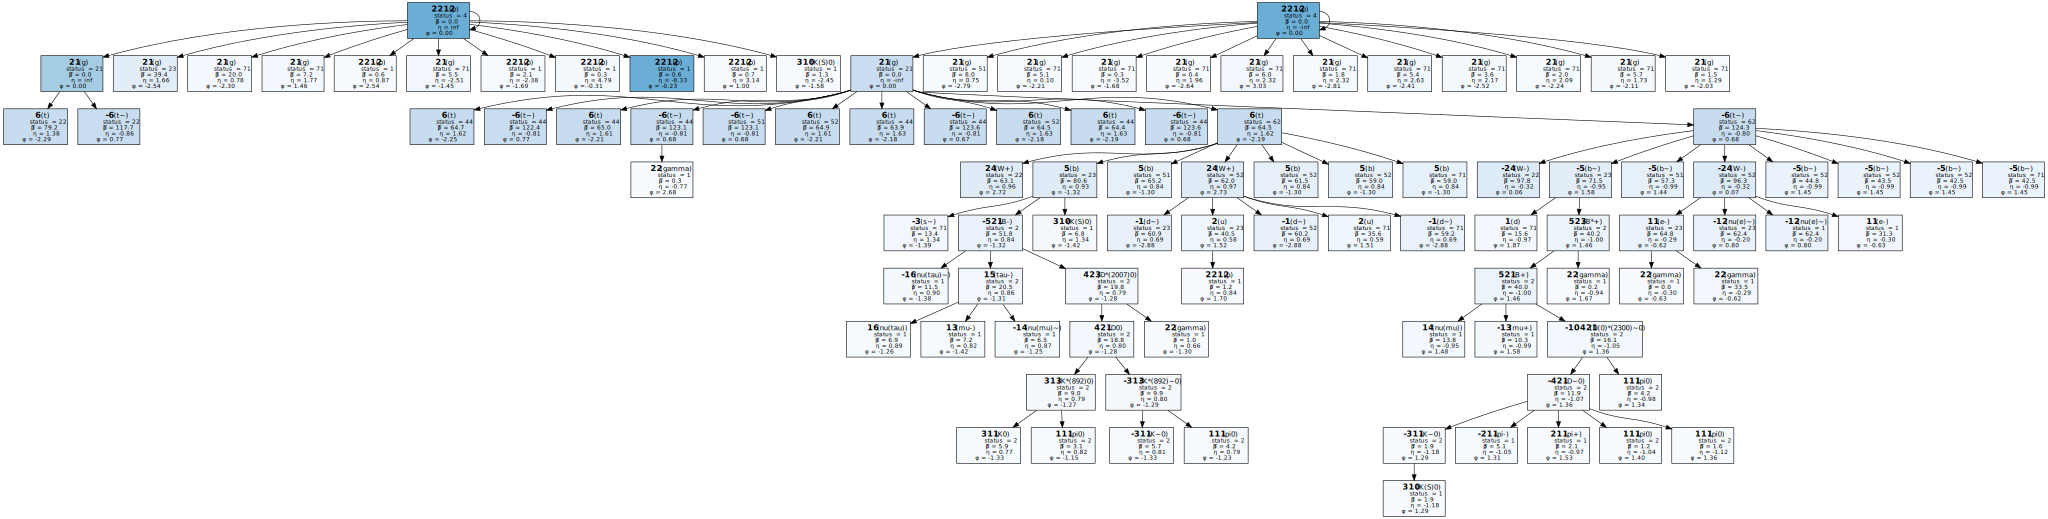

In [6]:
make_graph(df_cms4, "graph_cms4.svg")

uaf-10.t2.ucsd.edu/~namin/dump/graph_nano.svg


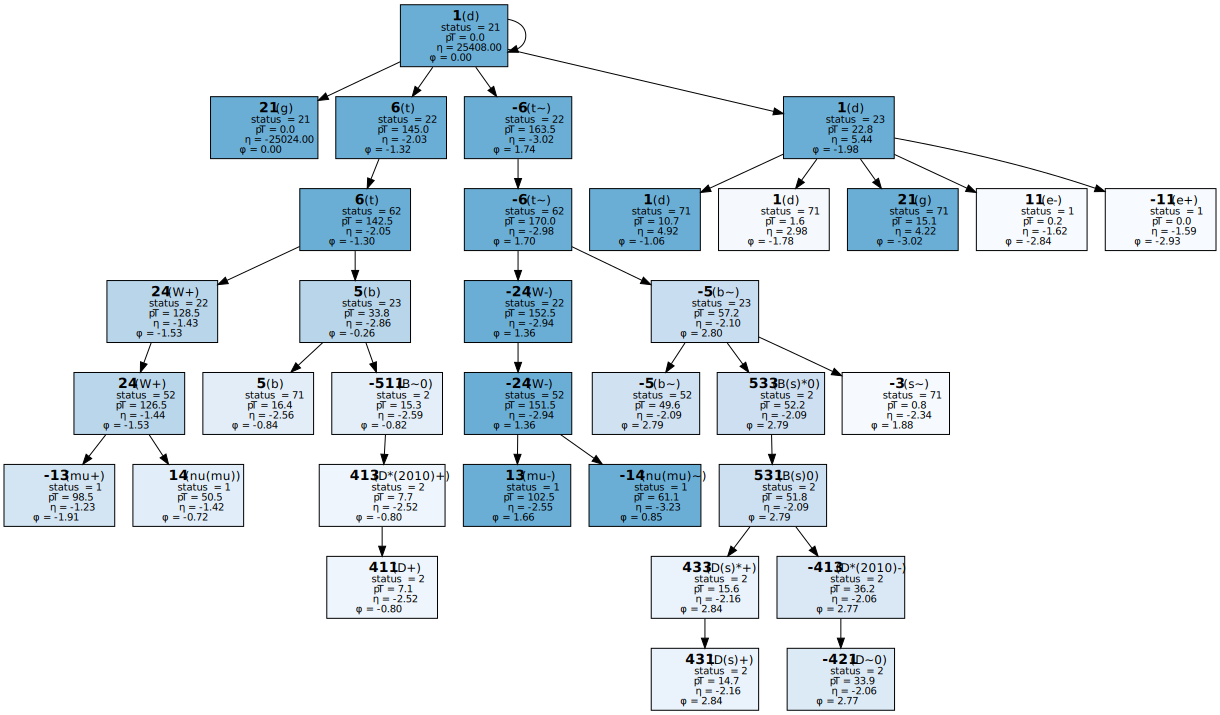

In [7]:
make_graph(df_nano, "graph_nano.svg")